# WIP Notebook

# Imports

In [1]:
import warnings

import branca.colormap as cm
import datetime
import folium
import holidays
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis, mode, pearsonr, skew
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeRegressor
from skrub import GapEncoder, TableVectorizer
import xgboost as xgb
from ydata_profiling import ProfileReport

In [2]:
# Import provided data
train = pd.read_parquet("/Users/pierrehaas/bike_counters/data/train.parquet")
test = pd.read_parquet("/Users/pierrehaas/bike_counters/data/final_test.parquet")

In [42]:
weather = pd.read_csv("/Users/pierrehaas/bike_counters/external_data/weather/H_75_previous-2020-2022.csv.gz", parse_dates=["AAAAMMJJHH"], date_format="%Y%m%d%H", compression="gzip", sep=";")

In [49]:
train.merge(weather, left_on="date", right_on="AAAAMMJJHH")

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,INS,QINS,INS2,QINS2,TLAGON,QTLAGON,TVEGETAUX,QTVEGETAUX,ECOULEMENT,QECOULEMENT
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0.0,9.0,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913615,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,15.0,2021-09-09 23:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2913616,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,15.0,2021-09-09 23:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2913617,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,15.0,2021-09-09 23:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,0.0,9.0,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2913618,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,15.0,2021-09-09 23:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

## Data Overview

### Provided data (train and test sets)

In [4]:
train.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [5]:
train.shape

(496827, 12)

In [6]:
train.dtypes

counter_id                         category
counter_name                       category
site_id                               int64
site_name                          category
bike_count                          float64
date                         datetime64[us]
counter_installation_date    datetime64[us]
coordinates                        category
counter_technical_id               category
latitude                            float64
longitude                           float64
log_bike_count                      float64
dtype: object

In [7]:
train.nunique()

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

In [8]:
train["date"].min(), train["date"].max()

(Timestamp('2020-09-01 01:00:00'), Timestamp('2021-09-09 23:00:00'))

In [9]:
test.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429


In [10]:
test.shape

(51440, 10)

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51440 entries, 0 to 51439
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   counter_id                 51440 non-null  category      
 1   counter_name               51440 non-null  category      
 2   site_id                    51440 non-null  int64         
 3   site_name                  51440 non-null  category      
 4   date                       51440 non-null  datetime64[us]
 5   counter_installation_date  51440 non-null  datetime64[us]
 6   coordinates                51440 non-null  category      
 7   counter_technical_id       51440 non-null  category      
 8   latitude                   51440 non-null  float64       
 9   longitude                  51440 non-null  float64       
dtypes: category(5), datetime64[us](2), float64(2), int64(1)
memory usage: 2.2 MB


In [12]:
test.nunique()

counter_id                    56
counter_name                  56
site_id                       30
site_name                     30
date                         933
counter_installation_date     22
coordinates                   30
counter_technical_id          30
latitude                      30
longitude                     30
dtype: int64

In [13]:
test["date"].min(), test["date"].max()

(Timestamp('2021-09-10 01:00:00'), Timestamp('2021-10-18 21:00:00'))

#### Train set exploration

##### Bike count by coordinates

In [14]:
# Calculate the total bike count per location
location_counts = train.groupby(["latitude", "longitude"])["bike_count"].sum().reset_index()

# Create a colormap
colormap = cm.linear.PuRd_09.scale(location_counts["bike_count"].min(), location_counts["bike_count"].max())

# Create the map
m = folium.Map(location=train[["latitude", "longitude"]].mean(axis=0).values, zoom_start=13)

# Add markers to the map
for _, row in location_counts.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=7,
        color=colormap(row["bike_count"]),
        fill=True,
        fill_color='black',  # Fill center with black
        fill_opacity=1,      # Ensure the fill is opaque
        popup=f"Bike Count: {row['bike_count']}"
    ).add_to(m)

# Add the colormap to the map
colormap.add_to(m)

m

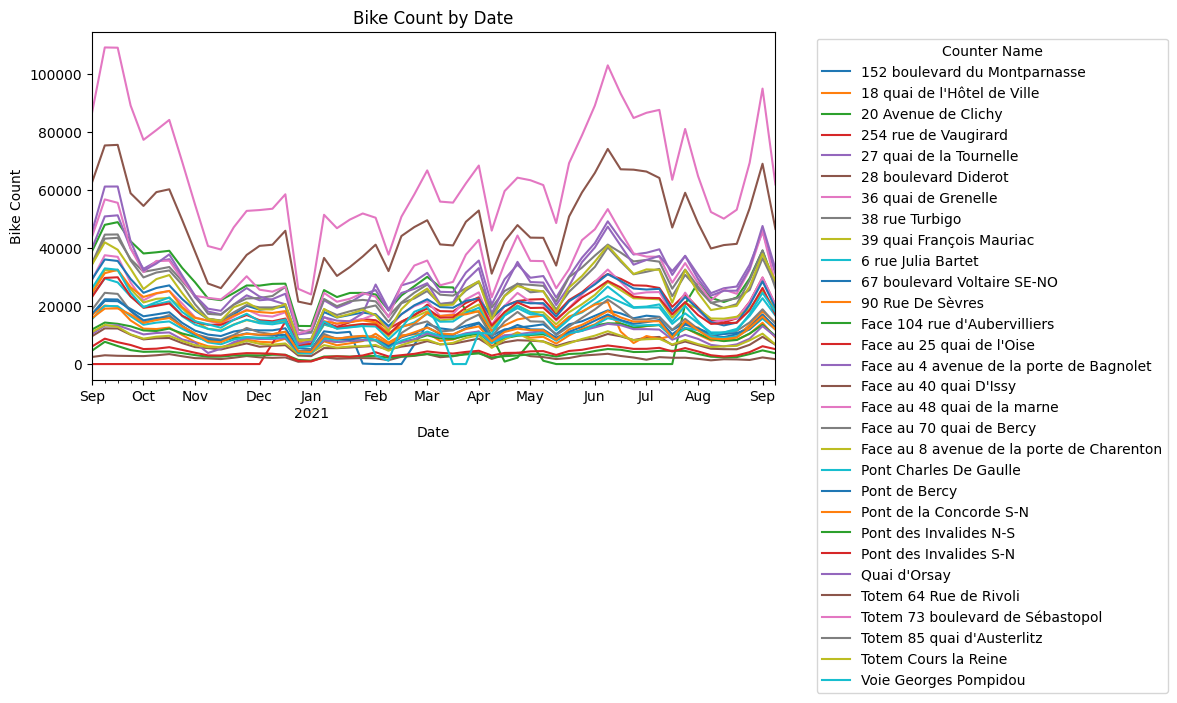

In [15]:
# Pivot the DataFrame so each counter name has its own column
pivot_df = (
    train.groupby([pd.Grouper(key="date", freq="W"), "site_name"], observed=False)["bike_count"]
    .sum()
    .unstack()
)

# Plot the data
pivot_df.plot(figsize=(12, 6))
plt.title("Bike Count by Date")
plt.xlabel("Date")
plt.ylabel("Bike Count")
plt.legend(title="Counter Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

##### Weekly bike count by site_name

In [16]:
train.groupby([pd.Grouper(key="date", freq="W"), "site_name"], observed=False)[
    "bike_count"
].sum().unstack()

site_name,152 boulevard du Montparnasse,18 quai de l'Hôtel de Ville,20 Avenue de Clichy,254 rue de Vaugirard,27 quai de la Tournelle,28 boulevard Diderot,36 quai de Grenelle,38 rue Turbigo,39 quai François Mauriac,6 rue Julia Bartet,...,Pont de Bercy,Pont de la Concorde S-N,Pont des Invalides N-S,Pont des Invalides S-N,Quai d'Orsay,Totem 64 Rue de Rivoli,Totem 73 boulevard de Sébastopol,Totem 85 quai d'Austerlitz,Totem Cours la Reine,Voie Georges Pompidou
date,,,,,,,,,,,,,,,,,,,,,
2020-09-06,16902.0,16949.0,38803.0,0.0,39748.0,9572.0,28939.0,34467.0,24648.0,23439.0,...,17276.0,15838.0,4595.0,6025.0,45437.0,62498.0,86444.0,34680.0,34209.0,26040.0
2020-09-13,21747.0,20168.0,48004.0,0.0,50907.0,12302.0,37516.0,43241.0,32397.0,29486.0,...,22330.0,19129.0,7677.0,8760.0,61196.0,75367.0,109156.0,44624.0,41960.0,32981.0
2020-09-20,21680.0,19715.0,48918.0,0.0,51277.0,12263.0,36962.0,43527.0,32247.0,28158.0,...,22262.0,19166.0,6206.0,7540.0,61213.0,75565.0,109069.0,44684.0,39417.0,32518.0
2020-09-27,19022.0,15031.0,42328.0,0.0,39875.0,10115.0,28095.0,36188.0,25884.0,23289.0,...,18420.0,17120.0,4803.0,6576.0,42319.0,58893.0,89158.0,35701.0,32874.0,24633.0
2020-10-04,16460.0,12214.0,38126.0,0.0,32840.0,8501.0,21993.0,31801.0,21217.0,19755.0,...,15070.0,14184.0,4215.0,5172.0,32221.0,54521.0,77298.0,29868.0,25860.0,19585.0
2020-10-11,17137.0,12076.0,38531.0,0.0,35326.0,8895.0,24264.0,32600.0,22492.0,20561.0,...,15891.0,15161.0,4301.0,5296.0,34650.0,59283.0,80661.0,31556.0,29292.0,21346.0
2020-10-18,17861.0,12578.0,39050.0,0.0,36143.0,8975.0,25212.0,33459.0,22792.0,21604.0,...,16145.0,15874.0,4311.0,5819.0,37807.0,60252.0,84167.0,32266.0,30680.0,22956.0
2020-10-25,14192.0,10016.0,33158.0,0.0,29804.0,7225.0,20873.0,28640.0,19286.0,16522.0,...,13038.0,12975.0,3764.0,4878.0,30541.0,49679.0,69739.0,27329.0,24459.0,17983.0
2020-11-01,11520.0,7609.0,28183.0,0.0,23024.0,5842.0,16093.0,23501.0,14861.0,13595.0,...,10304.0,10553.0,3086.0,3903.0,23563.0,38720.0,54942.0,20587.0,18931.0,14750.0


It seems like some sites are not capturing any data at all at times (multiple weeks sometimes). We will need to investigate this further.

Let's take a specific site that did not capture bikes for multiple weeks.

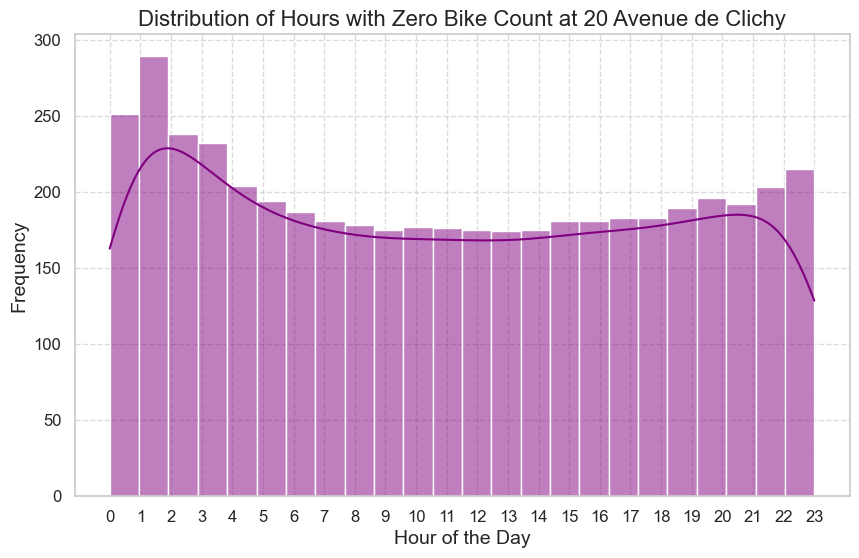

In [17]:
# Set the style
sns.set(style="whitegrid")

# Filter the data
filtered_data = train[(train["site_name"] == "20 Avenue de Clichy") & (train["bike_count"] == 0)]["date"].dt.hour

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data, bins=24, kde=True, color='purple')

# Add titles and labels
plt.title('Distribution of Hours with Zero Bike Count at 20 Avenue de Clichy', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize the ticks
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

We should try to find information about sites under repair (or else) to improve our model and make sure it predicts 0 bike_count when the site cannot capture data.

# Feature engineering

## Date Encoding

In [18]:
def date_encoder(X, col="date"):
    X = X.copy()  # modify a copy of X

    # Encode the date information from the DateOfDeparture columns
    X["year"] = X[col].dt.year
    X["quarter"] = X[col].dt.quarter
    X["month"] = X[col].dt.month
    X["day"] = X[col].dt.day
    X["weekday"] = X[col].dt.weekday + 1
    X["hour"] = X[col].dt.hour

    # Binary variable indicating weekend or not (1=weekend, 0=weekday)
    X["is_weekend"] = (X["weekday"] > 5).astype(int)

    # Binary variable indicating bank holiday or not (1=holiday, 0=not holiday)
    import holidays

    fr_bank_holidays = holidays.FR()  # Get list of FR holidays
    X["is_bank_holiday"] = X[col].apply(lambda x: 1 if x in fr_bank_holidays else 0)

    X = X.copy()  # modify a copy of X

    # Binary variable indicating school holiday or not (1=holiday, 0=not holiday)
    # https://www.data.gouv.fr/fr/datasets/vacances-scolaires-par-zones/
    fr_school_holidays = pd.read_csv(
        "/Users/pierrehaas/bike_counters/external_data/vacances_scolaires_france.csv"
    )[["date", "vacances_zone_c"]]

    # Ensure both DataFrames have a consistent datetime format
    X["date_normalized"] = pd.to_datetime(X[col]).dt.normalize()
    fr_school_holidays["date"] = pd.to_datetime(fr_school_holidays[col]).dt.normalize()

    # Create a dictionary from the holidays dataset for faster lookup
    holiday_mapping = dict(
        zip(fr_school_holidays["date"], fr_school_holidays["vacances_zone_c"])
    )

    # Map the normalized date to the holiday column
    X["is_school_holiday"] = (
        X["date_normalized"].map(holiday_mapping).fillna(0).astype(int)
    )

    # Drop the normalized date column if not needed
    X.drop(columns=["date_normalized"], inplace=True)

    # Finally, return the updated DataFrame
    return X

In [19]:
train_1 = date_encoder(train, col="date")
test_1 = date_encoder(test, col="date")

### EDA - Analysis of new features

In [20]:
train_1.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,log_bike_count,year,quarter,month,day,weekday,hour,is_weekend,is_bank_holiday,is_school_holiday
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0.000000,2020,3,9,1,2,2,0,0,0
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0.693147,2020,3,9,1,2,3,0,0,0
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0.000000,2020,3,9,1,2,4,0,0,0
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,1.609438,2020,3,9,1,2,15,0,0,0
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,2.302585,2020,3,9,1,2,18,0,0,0


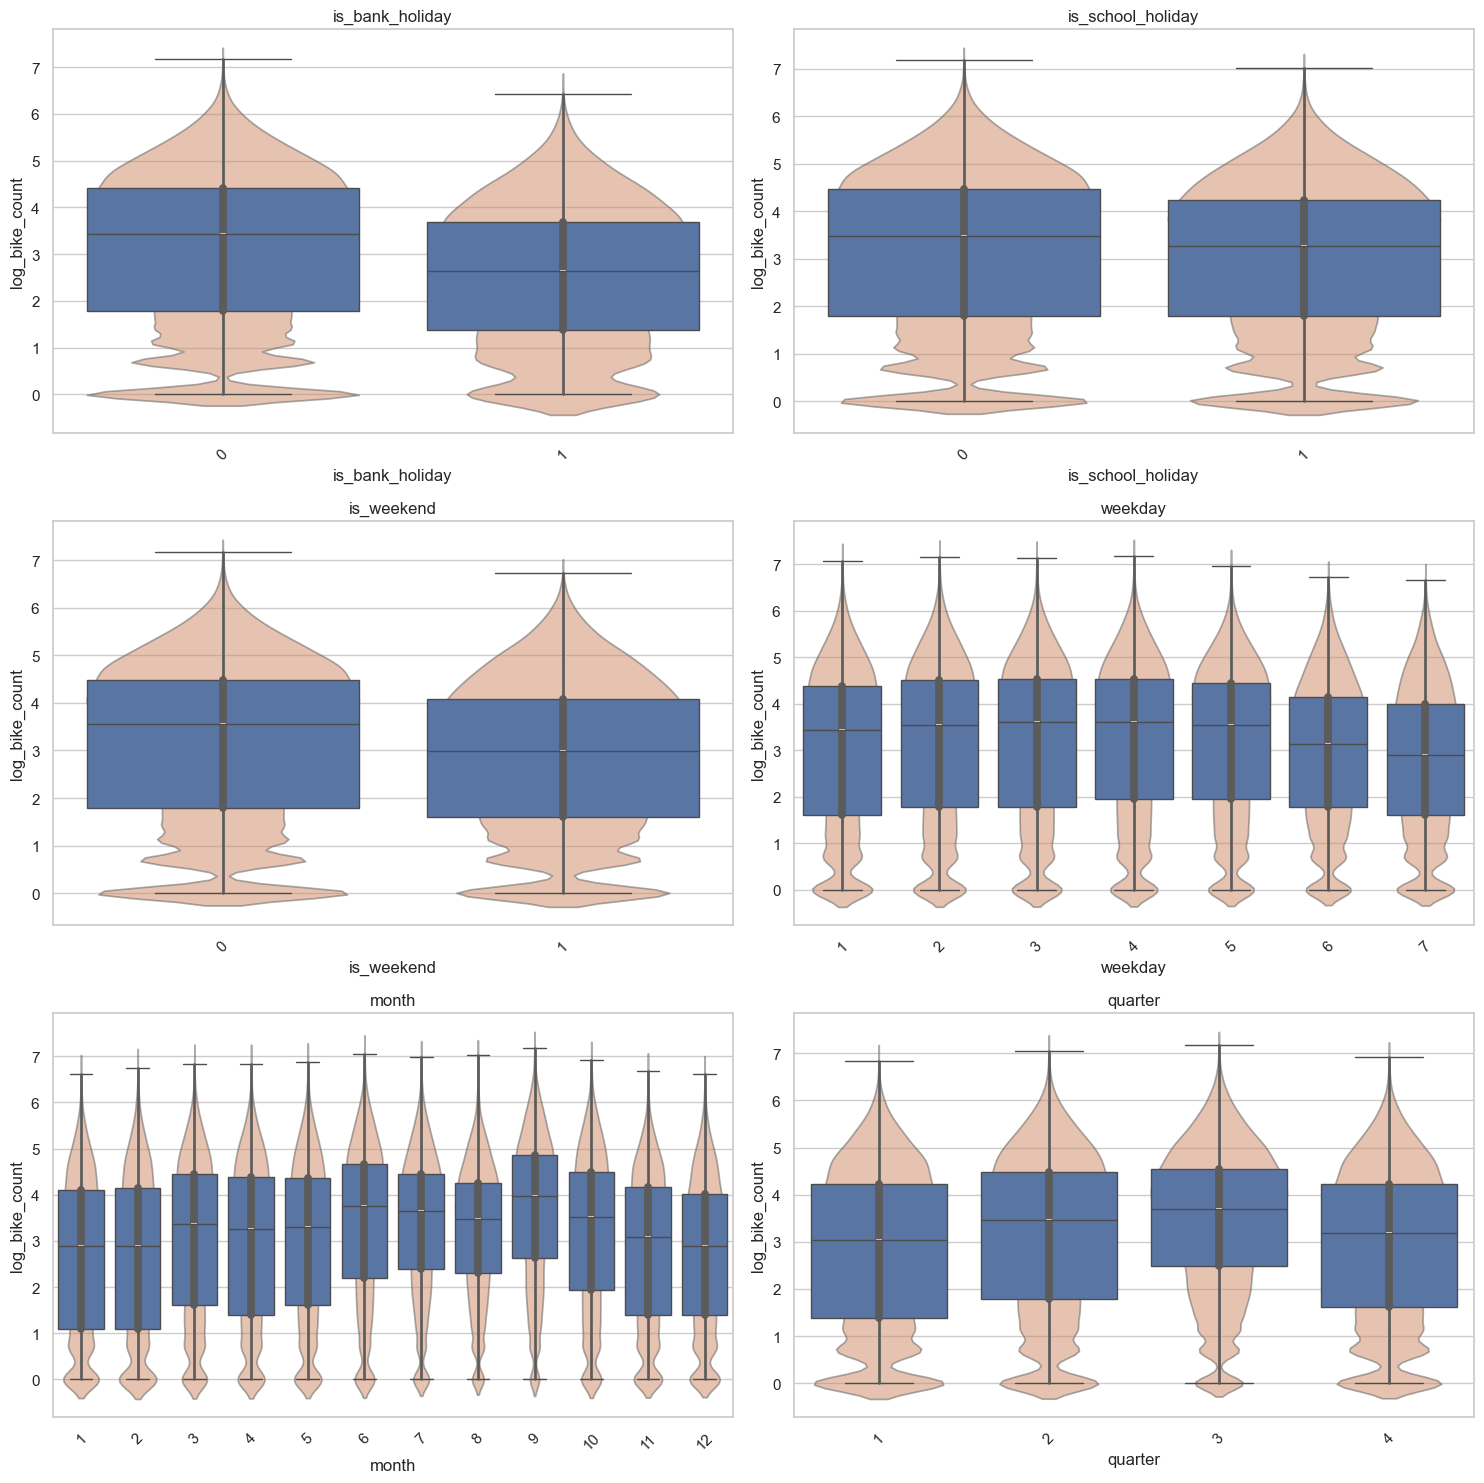

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot for 'is_bank_holiday'
sns.boxplot(ax=axes[0, 0], x=train_1["is_bank_holiday"], y=train_1["log_bike_count"])
plt.setp(axes[0, 0].artists, alpha=0.5)
sns.violinplot(ax=axes[0, 0], x=train_1["is_bank_holiday"], y=train_1["log_bike_count"])
plt.setp(axes[0, 0].collections, alpha=0.5)
axes[0, 0].set_title("is_bank_holiday")
axes[0, 0].tick_params(axis="x", rotation=45)

# Plot for 'is_school_holiday'
sns.boxplot(ax=axes[0, 1], x=train_1["is_school_holiday"], y=train_1["log_bike_count"])
plt.setp(axes[0, 1].artists, alpha=0.5)
sns.violinplot(
    ax=axes[0, 1], x=train_1["is_school_holiday"], y=train_1["log_bike_count"]
)
plt.setp(axes[0, 1].collections, alpha=0.5)
axes[0, 1].set_title("is_school_holiday")
axes[0, 1].tick_params(axis="x", rotation=45)

# Plot for 'is_weekend'
sns.boxplot(ax=axes[1, 0], x=train_1["is_weekend"], y=train_1["log_bike_count"])
plt.setp(axes[1, 0].artists, alpha=0.5)
sns.violinplot(ax=axes[1, 0], x=train_1["is_weekend"], y=train_1["log_bike_count"])
plt.setp(axes[1, 0].collections, alpha=0.5)
axes[1, 0].set_title("is_weekend")
axes[1, 0].tick_params(axis="x", rotation=45)

# Plot for 'weekday'
sns.boxplot(ax=axes[1, 1], x=train_1["weekday"], y=train_1["log_bike_count"])
plt.setp(axes[1, 1].artists, alpha=0.5)
sns.violinplot(ax=axes[1, 1], x=train_1["weekday"], y=train_1["log_bike_count"])
plt.setp(axes[1, 1].collections, alpha=0.5)
axes[1, 1].set_title("weekday")
axes[1, 1].tick_params(axis="x", rotation=45)

# Plot for 'month'
sns.boxplot(ax=axes[2, 0], x=train_1["month"], y=train_1["log_bike_count"])
plt.setp(axes[2, 0].artists, alpha=0.5)
sns.violinplot(ax=axes[2, 0], x=train_1["month"], y=train_1["log_bike_count"])
plt.setp(axes[2, 0].collections, alpha=0.5)
axes[2, 0].set_title("month")
axes[2, 0].tick_params(axis="x", rotation=45)

# Plot for 'quarter'
sns.boxplot(ax=axes[2, 1], x=train_1["quarter"], y=train_1["log_bike_count"])
plt.setp(axes[2, 1].artists, alpha=0.5)
sns.violinplot(ax=axes[2, 1], x=train_1["quarter"], y=train_1["log_bike_count"])
plt.setp(axes[2, 1].collections, alpha=0.5)
axes[2, 1].set_title("quarter")
axes[2, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

#### Poubelle

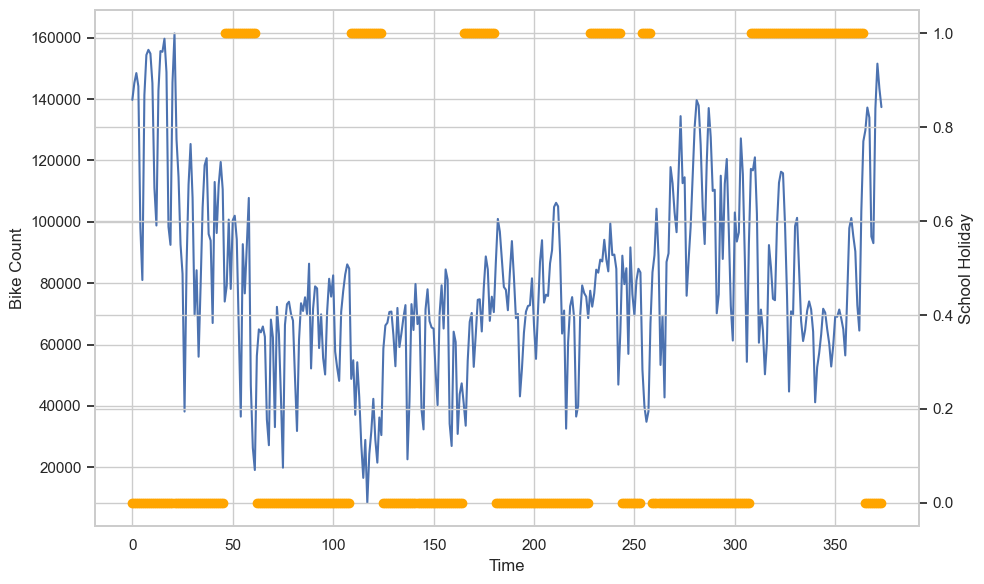

In [22]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the line on the primary y-axis
ax1.plot(
    train_1.groupby(["year", "month", "day"])["bike_count"]
    .sum()
    .reset_index(drop=True),
    label="Bike Count",
)
ax1.set_xlabel("Time")
ax1.set_ylabel("Bike Count")

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.scatter(
    np.arange(0, 374),
    np.clip(train_1.groupby(["year", "month", "day"])["is_school_holiday"].sum(), 0, 1),
    color="orange",
    label="School Holiday",
)
ax2.set_ylabel("School Holiday")

fig.tight_layout()
plt.show()

## Introducing lag features

In [23]:
train_2 = train_1.sort_values(["counter_id", "date"]).copy()

# Shift of the previous bike count
train_2["1h_shift_bike_count"] = train_2.groupby("counter_id", observed=False)["bike_count"].shift(1)

# Shift of the average bike count over the last 24 hours
train_2["24h_avg_shift_bike_count"] = train_2.groupby("counter_id", observed=False)["bike_count"].rolling(window=24).mean().shift(1).reset_index(level=0, drop=True)

# Shift of the average bike count over the last week (7 days * 24 hours)
train_2["1w_avg_shift_bike_count"] = train_2.groupby("counter_id", observed=False)["bike_count"].rolling(window=7*24).mean().shift(1).reset_index(level=0, drop=True)

In [24]:
train_3 = train_2[train_2["1w_avg_shift_bike_count"] != 0].drop(columns=["1h_shift_bike_count", "24h_avg_shift_bike_count", "1w_avg_shift_bike_count"])

## Feature encoding

In [25]:
# preprocessor = ColumnTransformer()

# Testing

## Finetuning

## Output

In [26]:
X_train = train_1.drop(columns=["bike_count", "log_bike_count", "date"])
y_train = train_1["log_bike_count"]

X_test = test_1.drop(columns=["date"])

model = xgb.XGBRegressor()

pipe = Pipeline(
    steps=[
        ("preprocessor", TableVectorizer()),
        ("regressor", model),
    ]
)

pipe.fit(X_train, y_train)
y_test = pipe.predict(X_test)

pd.DataFrame(y_test, columns=["log_bike_count"]).reset_index().rename(
    columns={"index": "Id"}
).to_csv("/Users/pierrehaas/bike_counters/predictions.csv", index=False)

In [29]:
pd.DataFrame(y_test, columns=["log_bike_count"]).reset_index().rename(
    columns={"index": "Id"}
)

,Id,log_bike_count
0,0,0.555159
1,1,1.656973
2,2,2.013048
3,3,1.010027
4,4,0.954913
...,...,...
51435,51435,4.680541
51436,51436,5.082195
51437,51437,5.461224
51438,51438,5.033281


In [27]:
# pipe.named_steps["preprocessor"]

# Poubelle